## Word Embeddings For Text Classification
Source: https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/Document%20classification%20with%20word%20embeddings%20tutorial.ipynb

Slides with Notes: https://www.slideshare.net/YiShinChen1/quick-tour-of-text-mining

### TASK: 

Classify Movie plots by genre using word embeddings techniques in Gensim

### REPO:
https://goo.gl/ppHX65

### Requirements:

#### Software:
------------------

* Python 3 (coding will be done strictly using Python)
* Anaconda Environment (recommended but not mandatory) (https://www.continuum.io/downloads)
* Jupyter (http://jupyter.org/)
* Google's word2vec (Download the file... warning! it is really huge)(https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)
* Gensim (https://radimrehurek.com/gensim/)
* Scikit Learn (http://scikit-learn.org/stable/) (get the latest version)
* Pandas (http://pandas.pydata.org/)
* Matplotlib (https://matplotlib.org/)
* NLTK (for stopwords) (http://www.nltk.org/)

#### Computing Resources:
-------------------
* Operating System: Preferably Linux or MacOS (Windows break but you can try it out)
* RAM: 4GB 
* Disk Space: 8GB (mostly to store word embeddings)

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords
from helpers import *

%matplotlib inline

## Data Exploration
---

In [115]:
# read reviews
df = pd.read_csv('data/movie_reviews/tagged_plots_movielens.csv')
df = df.dropna()

# count the number of words
df['plot'].apply(lambda x: len(x.split(' '))).sum()

171156

**Exercise:** Plot tokens by frequency

**Note:** Usually at least 500K words are suggested to train word2vec model, so performance may be unsual here

We only have (1/5th) therefore some models may not peform very well.

In [34]:
df[:10]

,Unnamed: 0,movieId,plot,tag
0,0,1,A little boy named Andy loves to be in his roo...,animation
1,1,2,When two kids find and play a magical board ga...,fantasy
2,2,3,Things don't seem to change much in Wabasha Co...,comedy
3,3,6,Hunters and their prey--Neil and his professio...,action
4,4,7,An ugly duckling having undergone a remarkable...,romance
5,5,9,Some terrorists kidnap the Vice President of t...,action
6,6,10,James Bond teams up with the lone survivor of ...,action
7,7,15,"Morgan Adams and her slave, William Shaw, are ...",action
8,8,17,"When Mr. Dashwood dies, he must leave the bulk...",romance
9,9,18,This movie features the collaborative director...,comedy


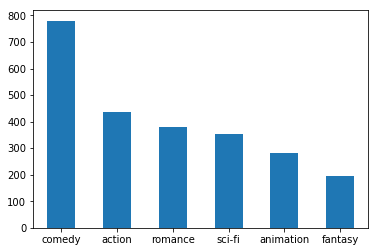

In [35]:
# classes
my_tags = ['sci-fi' , 'action', 'comedy', 'fantasy', 'animation', 'romance']
df.tag.value_counts().plot(kind="bar", rot=0)

**Note:** Unbalanced dataset; Comedy has significantly more examples than the rest of the classes (40% overall)

**TODO:** Do some more text mining exploration and statistical inferences here

In [36]:
# split the data (90/10)
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)

In [37]:
len(test_data), len(train_data)

(243, 2184)

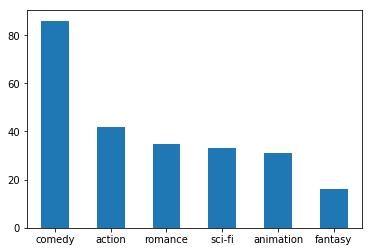

In [38]:
# distribution of the test data
test_data.tag.value_counts().plot(kind="bar", rot=0)

## Train Naive Models (Baselines)
---
* Bag of words
* N-grams
* TF-IDF

### 1. Bag of Words
Using scikitlearn CountVectorizer

In [39]:
# training
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=3000) 

# choose what are the features
train_data_features = count_vectorizer.fit_transform(train_data['plot'])

**Excercise**: Authors only use logistic regression but we can also train with naive bayesian, random forest, gradient boosting, and deep neural networks

In [40]:
logreg_model = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg_model = logreg_model.fit(train_data_features, train_data['tag'])

In [41]:
# oberve some features
count_vectorizer.get_feature_names()[2899:2910]

['warrior',
 'warriors',
 'wars',
 'washington',
 'watch',
 'watches',
 'watching',
 'water',
 'waters',
 'way',
 'wayne']

In [42]:
# amount of features detected (3000)
train_data_features[0]

<1x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 43 stored elements in Compressed Sparse Row format>

accuracy 0.423868312757
confusion matrix
 [[21  2 10  1  4  4]
 [ 4 10  8  0  3  6]
 [10 11 45  3 16  1]
 [ 1  5  3  4  3  0]
 [ 1  3 15  2 11  3]
 [ 8  5  6  2  0 12]]
(row=expected, col=predicted)


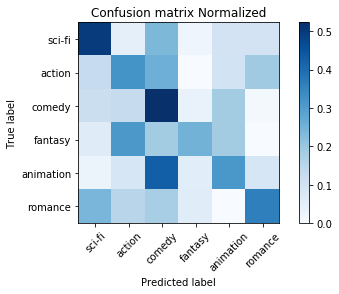

In [43]:
word_embeddings.predict(count_vectorizer, logreg_model, test_data, my_tags)

**Note 1**: Classifier performs slighly better than chance. 40% if the classifier said all were comedy and 42% with the bag of word model

In [44]:
# words for the action genre
comedy_tag_id = word_embeddings.get_tag_index(my_tags, "comedy")
comedy_words = word_embeddings.most_influential_words(logreg_model, count_vectorizer, \
                                                      comedy_tag_id, 3000)
comedy_words = pd.DataFrame(comedy_words)

In [45]:
comedy_words[:10]

,0,1
0,mistaken,11.810842
1,jewish,10.668508
2,suspects,10.104922
3,comedy,9.949616
4,dealer,9.775865
5,comedian,9.634339
6,operation,9.512068
7,stuart,9.323364
8,actress,9.232942
9,dimension,9.097288


In [46]:
# words for the action genre
animation_tag_id = word_embeddings.get_tag_index(my_tags, "animation")
animation_words = word_embeddings.most_influential_words(logreg_model, count_vectorizer,\
                                                         animation_tag_id, 3000)
animation_words = pd.DataFrame(animation_words)

In [47]:
# the most influential words for the animation category
animation_words[:10]

,0,1
0,nazi,8.946895
1,sisters,8.870921
2,troubled,8.720853
3,affair,8.603380
4,revealed,8.499657
5,relationships,8.112722
6,decide,8.016373
7,spending,7.919799
8,wolf,7.470311
9,photographer,7.268472


In [48]:
# words for the action genre
fantasy_tag_id = word_embeddings.get_tag_index(my_tags, "fantasy")
fantasy_words = word_embeddings.most_influential_words(logreg_model, count_vectorizer,\
                                                       fantasy_tag_id, 3000)
fantasy_words = pd.DataFrame(fantasy_words)

# the most influential words for the animation category
fantasy_words[:10]

,0,1
0,national,15.013773
1,chosen,7.682396
2,princess,6.555631
3,prove,6.072531
4,beast,5.901359
5,fan,5.886863
6,moving,5.641193
7,fantasies,5.636695
8,director,5.516928
9,angel,5.485528


In [49]:
# Check what are the words that overlap between comedy and animation
word_embeddings.check_word_overlap(comedy_words[:500][0], animation_words[:500][0])

[[['jay', 12],
  ['insane', 114],
  ['lawyer', 116],
  ['environment', 162],
  ['marry', 166],
  ['did', 170],
  ['sons', 222],
  ['hunting', 302],
  ['boys', 318],
  ['asked', 323],
  ['jobs', 336],
  ['opportunity', 341],
  ['heading', 408],
  ['threatened', 414],
  ['american', 427],
  ['brooklyn', 428],
  ['turned', 429],
  ['late', 445],
  ['chinese', 450],
  ['president', 453],
  ['ready', 456],
  ['look', 469],
  ['england', 488]],
 23]

### 2. Character N-grams

A character n-gram is a chunk of a document of length n. It is a poor man's tokenizer but sometimes works well. The parameter n depends on language and the corpus. We choose length between 3 and 6 characters and to only focus on 3k most popular ones. 3K is a fair comparison since the previous bag of words model was this size as well.

In [50]:
n_gram_vectorizer = CountVectorizer(
    analyzer="char",
    ngram_range=([2,5]),
    tokenizer=None,    
    preprocessor=None,                               
    max_features=3000) 

charn_model = linear_model.LogisticRegression(n_jobs=1, C=1e5)

train_data_features = n_gram_vectorizer.fit_transform(train_data['plot'])

charn_model = charn_model.fit(train_data_features, train_data['tag'])

In [51]:
# some features
n_gram_vectorizer.get_feature_names()[100:120]

[' chil',
 ' ci',
 ' cit',
 ' cl',
 ' co',
 ' col',
 ' com',
 ' come',
 ' comp',
 ' con',
 ' cont',
 ' cou',
 ' cr',
 ' cre',
 ' cu',
 ' d',
 ' da',
 ' dan',
 ' day',
 ' de']

accuracy 0.399176954733
confusion matrix
 [[17  3 12  1  5  4]
 [ 4  9  9  4  1  4]
 [12 10 41  6 15  2]
 [ 2  1  2  5  1  5]
 [ 5  1 15  1 11  2]
 [ 8  1  7  3  0 14]]
(row=expected, col=predicted)


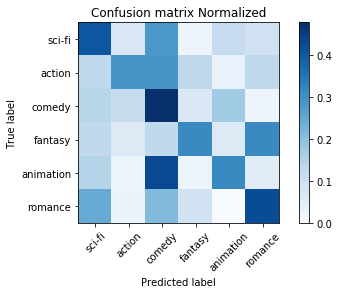

In [52]:
word_embeddings.predict(n_gram_vectorizer, charn_model, test_data, my_tags)

**Note**: The model performs really bad :_(, even worst than chance. Perhaps we can improve it by removing stopwords. 30% accuracy

### 3. TF-IDF
Term Frequency - Inverse Document Frequency is useful to rank importance of words to documents

In [53]:
tf_vect = TfidfVectorizer(
    min_df=2, tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english')
train_data_features = tf_vect.fit_transform(train_data['plot'])

tfidf_model = linear_model.LogisticRegression(n_jobs=1, C=1e5)
tfidf_model = tfidf_model.fit(train_data_features, train_data['tag'])

In [54]:
tf_vect.get_feature_names()[1000:1010]

['caesar',
 'cage',
 'caine',
 'cal',
 'calhoun',
 'california',
 'californians',
 'called',
 'calling',
 'callous']

accuracy 0.465020576132
confusion matrix
 [[23  2 12  2  2  1]
 [ 3 10 10  1  3  4]
 [ 9  6 49  0 21  1]
 [ 3  4  1  4  2  2]
 [ 1  2 20  0 11  1]
 [ 9  2  5  1  0 16]]
(row=expected, col=predicted)


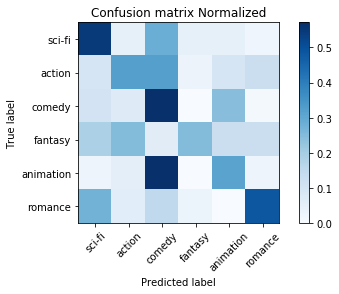

In [55]:
word_embeddings.predict(tf_vect, tfidf_model, test_data, my_tags)

Let us do some analysis on the model now

In [56]:
# words for the comedy genre
comedy_tag_id = word_embeddings.get_tag_index(my_tags, "comedy")
comedy_words = word_embeddings.most_influential_words(tfidf_model, tf_vect, comedy_tag_id, 3000)
comedy_words[0:10]

[['comedy', 24.5992977289301],
 ['jewish', 21.111621307928754],
 ['mistaken', 20.906784380688975],
 ['kindergarten', 20.550050838076675],
 ['duo', 20.039310378863604],
 ['dimension', 19.730576933476108],
 ['beloved', 19.655031499523833],
 ['dealer', 19.190813922478519],
 ['street', 18.766362320888405],
 ['tramp', 18.567543420444927]]

In [57]:
# words for the fantasy genre
fantasy_tag_id = word_embeddings.get_tag_index(my_tags, "fantasy")
fantasy_words = word_embeddings.most_influential_words(tfidf_model, tf_vect, fantasy_tag_id, 3000)
fantasy_words[0:10]

[['edward', 17.405228729634185],
 ['magical', 16.525441688448286],
 ['kingdom', 15.293991691029369],
 ['adventures', 14.936271113826516],
 ['percy', 14.809172140901389],
 ['moving', 14.203174472333552],
 ['land', 14.153599202700454],
 ['demon', 14.140054691071217],
 ['fan', 14.042094086775878],
 ['king', 13.98948584958028]]

Now let us observe what are the most influential words for a given movie plot

In [58]:
word_embeddings.most_influential_words_doc(train_data['plot'][0], fantasy_words)

['boy',
 'loves',
 'playing',
 'come',
 'worry',
 'family',
 'does',
 'mother',
 'action',
 'quickly',
 'tries',
 'rid',
 'ruthless',
 'toy']

**Note:** As you can see from the list above, there are words, such as *does* and *tries* that are not so relevant to the *fantasy* category. Therefore, we can still do better with this model. 

**Excercise:** Head to [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) and try to use different parameter for the TF-IDF vectorizer, such as modifying the *ngram_range*. It might improve the performance of the classifier. 

## Averaging Word Vectors (word2vec)

**SOURCE:** https://code.google.com/archive/p/word2vec/

First we are going to use a pretrained model open source by Google (word2vec)

In [59]:
wv = gensim.models.KeyedVectors.load_word2vec_format(
    "data/google_word2vec/GoogleNews-vectors-negative300.bin.gz",
    binary=True)
wv.init_sims(replace=True)

2017-06-28 22:11:11,385 : INFO : loading projection weights from data/google_word2vec/GoogleNews-vectors-negative300.bin.gz
2017-06-28 22:13:00,195 : INFO : loaded (3000000, 300) matrix from data/google_word2vec/GoogleNews-vectors-negative300.bin.gz
2017-06-28 22:13:00,195 : INFO : precomputing L2-norms of word weight vectors


**Excercise:** Create a function for exploring the word2vec file and find ways to visualize the results

**Preprocessing:** Here we tokenize both the training and testing datasets before creating the vectors with word2vec. Think of this as a filtering step. In this case words with `len(word)<2` are removed.

In [60]:
# test_tokenized = test_data.apply(lambda r: word2vec_helpers.w2v_tokenize_text(r['plot']), axis=1).values

In [61]:
# train_tokenized = train_data.apply(lambda r: word2vec_helpers.w2v_tokenize_text(r['plot']), axis=1).values

In [62]:
# store the data as pickle for retrieving later
#pickle_helpers.convert_to_pickle(train_tokenized, "data/movie_reviews/train.p")

# retrieve pickled version of test and train tokenized
test_tokenized = pickle_helpers.load_from_pickle("data/movie_reviews/test.p")
train_tokenized = pickle_helpers.load_from_pickle("data/movie_reviews/train.p")

In [63]:
train_tokenized[0:10]

array([ list(['Turkish', 'and', 'his', 'close', 'friend/accomplice', 'Tommy', 'get', 'pulled', 'into', 'the', 'world', 'of', 'match', 'fixing', 'by', 'the', 'notorious', 'Brick', 'Top', 'Things', 'get', 'complicated', 'when', 'the', 'boxer', 'they', 'had', 'lined', 'up', 'gets', 'badly', 'beaten', 'by', 'Pitt', "'pikey", 'slang', 'for', 'an', 'Irish', 'Gypsy', 'who', 'comes', 'into', 'the', 'equation', 'after', 'Turkish', 'an', 'unlicensed', 'boxing', 'promoter', 'wants', 'to', 'buy', 'caravan', 'off', 'the', 'Irish', 'Gypsies', 'They', 'then', 'try', 'to', 'convince', 'Pitt', 'not', 'only', 'to', 'fight', 'for', 'them', 'but', 'to', 'lose', 'for', 'them', 'too', 'Whilst', 'all', 'this', 'is', 'going', 'on', 'huge', 'diamond', 'heist', 'takes', 'place', 'and', 'fistful', 'of', 'motley', 'characters', 'enter', 'the', 'story', 'including', "'Cousin", 'Avi', "'Boris", 'The', 'Blade', "'Franky", 'Four', 'Fingers', 'and', "'Bullet", 'Tooth', 'Tony', 'Things', 'go', 'from', 'bad', 'to', 'wor

Next, we have to convert the words into a distributed representation (in other words, each token must be conversed into vector). Since we are using word2vec the convesion can be done easily.

Now that we have the vectors, we can obtain vectors for an entire document, by averaging word vectors. (Warning: very naive appraoch!)

![alt txt](https://docs.google.com/drawings/d/1m1Uod7QU4iSN7J3iqsTU6JRWdGTEJRZ2dA7rZrgNHgA/pub?w=942&h=375)

In [64]:
X_train_word_average = word2vec_helpers.word_averaging_list(wv,train_tokenized)

In [65]:
X_test_word_average = word2vec_helpers.word_averaging_list(wv,test_tokenized)

In [66]:
X_train_word_average[0]

array([ 0.05545449,  0.05910575,  0.04342501,  0.07156485, -0.06337085,
       -0.04693267,  0.02318664, -0.0889559 ,  0.06699731,  0.08280275,
       -0.02325549, -0.11232544, -0.01920838,  0.04011356, -0.11890385,
        0.03739267,  0.0560286 ,  0.08226582,  0.02232919, -0.04910114,
       -0.00497308,  0.04151743,  0.02096887, -0.00108779,  0.08315163,
        0.00165053, -0.10190015,  0.0887218 ,  0.04294581,  0.02587495,
       -0.01478133,  0.02559877, -0.03495957, -0.00126466,  0.03815735,
        0.00277985, -0.00618378, -0.0127198 ,  0.04081891,  0.07088073,
        0.09200442, -0.08722563,  0.11710441, -0.04684571, -0.02880416,
       -0.00468458, -0.05068978, -0.00313703,  0.06019693,  0.06222438,
       -0.01847018,  0.11511943, -0.00197043, -0.07153045, -0.03648838,
        0.04271036, -0.02165449, -0.06775223,  0.01724528, -0.07145506,
       -0.04500109,  0.0923021 , -0.07771284, -0.11304772, -0.03642419,
       -0.02397631,  0.00947447,  0.06566761, -0.04847883,  0.07

### Further exploration  of word2vec generated vectors
Some tips here: https://radimrehurek.com/gensim/models/keyedvectors.html

In [67]:
wv.syn0norm[wv.vocab['Murtuza'].index] # (300,)
#wv.vocab['woman'].index

array([ -8.43075514e-02,   9.63514894e-02,   6.45992905e-02,
         6.89789057e-02,   3.52193899e-02,   1.74272116e-02,
        -6.05846494e-02,  -9.63514894e-02,  -7.00738132e-02,
         2.60951947e-02,  -2.97448728e-02,   4.58034538e-02,
        -4.89056818e-02,   3.55843566e-02,  -6.05846494e-02,
        -3.67248803e-03,   2.93799043e-02,  -3.04748081e-02,
        -3.10222600e-02,   4.96356152e-02,  -1.32118329e-01,
        -6.60591647e-02,   1.71534847e-02,   6.67890981e-02,
         7.81031027e-02,  -9.78113636e-02,  -7.25373439e-03,
         4.31118160e-03,  -7.52746034e-03,  -9.48916152e-02,
        -1.00001164e-01,  -3.50369066e-02,   8.50374922e-02,
         1.72447264e-02,  -3.48544233e-02,  -5.21903895e-02,
        -3.22996452e-02,   1.53286457e-02,  -4.58490755e-03,
        -5.83948418e-02,   9.34317484e-02,   7.95629695e-02,
        -2.14418564e-02,   2.40878724e-02,  -2.64601633e-02,
        -8.72272924e-02,  -6.47247536e-04,  -6.60591647e-02,
         9.63514894e-02,

In [68]:
wv.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.7118191719055176),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411403656006)]

In [120]:
wv.most_similar(positive=['GOP', 'Trump'], negative=['money'])

[('Donald_Trump', 0.492326557636261),
 ('Mexican', 0.43394654989242554),
 ('Aguilar_Zinser', 0.4289255142211914),
 ('México', 0.4275927245616913),
 ('Mexcio', 0.4245557487010956),
 ('Jorge_Castañeda', 0.42415398359298706),
 ('Celaya_Guanajuato', 0.4219090938568115),
 ('Guatemala', 0.41712844371795654),
 ('Bosques_de_las_Lomas', 0.41683387756347656),
 ('Peru', 0.4160282015800476)]

For fun, let us try to manually compute the cosine similarity of some of our word vectors, which is computed as follows:
![alt txt](https://docs.google.com/drawings/d/1QI_5_uxopOYgk2PzU_RMTUGKkoNhJp81aIz4SUwsHIM/pub?w=956&h=263)

In [117]:
word_embeddings.cosine_measure(wv.syn0norm[wv.vocab['gun'].index], wv.syn0norm[wv.vocab['pistol'].index])

0.76924075586436913

---

### KNN Classification

Now we train a KNN and a logistic regression classifier and observe how they perfom on these word-averaging document features

Read about KNN- https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm

![alt txt](https://docs.google.com/drawings/d/13xu1RP3pVem277_eT900af7iz_MvTQUrLoxzWAewb_o/pub?w=817&h=614)

In [71]:
knn_naive_dv = KNeighborsClassifier(n_neighbors=3, n_jobs=1, algorithm='brute', metric='cosine' )
knn_naive_dv.fit(X_train_word_average, train_data.tag)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='cosine',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [72]:
predicted = knn_naive_dv.predict(X_test_word_average)

accuracy 0.38683127572
confusion matrix
 [[22  4  6  1  6  3]
 [ 9  4  9  4  5  0]
 [18  4 44  3 13  4]
 [ 7  3  1  2  1  2]
 [13  0  9  1 11  1]
 [13  2  1  4  2 11]]
(row=expected, col=predicted)


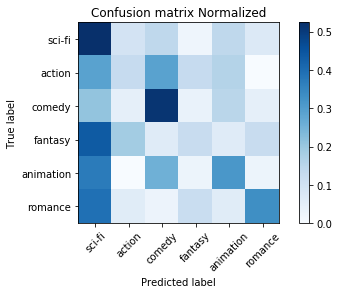

In [73]:
word_embeddings.evaluate_prediction(predicted, test_data.tag, my_tags)

KNN doesn't perform well (only 38%), even lower than chance. 

In [74]:
test_data.iloc()[56]['plot']

'Scruffy but irresistibly attractive Yau Muk-yan, without a job or a place to live, moves in with sensitive, shy piano tuner Chan Kar-fu. Both are disturbed, then obsessed, by the amateurish piano playing of upstairs neighbour Mok Man-yee. Obsession turns to romance, and romance to fantasy. The film is structured in four "movements": two themes (Yau Muk-yan, Mok Man-yee), a duet (Yau Muk-yan & Mok Man-yee), and a set of variations (a wild fantasy of Chan Kar-fu in his new novel).'

In [75]:
wv.most_similar(positive=[X_test_word_average[56]], restrict_vocab=100000, topn=30)[0:20]

[('just', 0.5038168430328369),
 ('but', 0.5023055076599121),
 ('in', 0.49800050258636475),
 ('the', 0.4957137107849121),
 ('so', 0.4889165759086609),
 ('actually', 0.4778650999069214),
 ('By_TBT_staff', 0.4743911623954773),
 ('even', 0.47195717692375183),
 ('really', 0.4685917794704437),
 ('anyway', 0.4660709500312805),
 ('vice_versa', 0.45745164155960083),
 ('one', 0.4536522626876831),
 ('sort', 0.4488521218299866),
 ('that', 0.4462577700614929),
 ('dreamy', 0.44418084621429443),
 ('You_EIG', 0.44372493028640747),
 ('kind', 0.442863404750824),
 ('then', 0.44108718633651733),
 ('obviously', 0.4360683262348175),
 ('Chan', 0.43542975187301636)]

The problem with the is that the average of this particular document fall under some area that is not related to the original document.

**Excercise:** Try to remove stopwords, the function is already provided. Try to figure out how to solve this using the current implementation of the function. Also, report the accuracy you achieved.

## Doc2Vec
Paper: https://cs.stanford.edu/~quocle/paragraph_vector.pdf
It is a **semi-supervised** approach since a **weak label or tag** (you can put many) is introduced into training documents before modeling. Read more about semi-supervised appraoches here: https://en.wikipedia.org/wiki/Semi-supervised_learning

![alt txt](https://docs.google.com/drawings/d/1TT6jNhk8rVoWMQajb8AIXCtyug0t_YVVZrvFidDPUPU/pub?w=679&h=375)

In [76]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [77]:
train_tagged = train_data.apply(
    lambda r: TaggedDocument(words=word_embeddings.tokenize_text(r['plot']), tags=[r.tag]), axis=1)

In [78]:
test_tagged = test_data.apply(
    lambda r: TaggedDocument(words=word_embeddings.tokenize_text(r['plot']), tags=[r.tag]), axis=1)

In [79]:
test_tagged.values[50]

TaggedDocument(words=['troubled', 'psychologist', 'is', 'sent', 'to', 'investigate', 'the', 'crew', 'of', 'an', 'isolated', 'research', 'station', 'orbiting', 'bizarre', 'planet'], tags=['sci-fi'])

In [80]:
trainsent = train_tagged.values
testsent = test_tagged.values

In [81]:
trainsent

array([ TaggedDocument(words=['turkish', 'and', 'his', 'close', 'friend/accomplice', 'tommy', 'get', 'pulled', 'into', 'the', 'world', 'of', 'match', 'fixing', 'by', 'the', 'notorious', 'brick', 'top', 'things', 'get', 'complicated', 'when', 'the', 'boxer', 'they', 'had', 'lined', 'up', 'gets', 'badly', 'beaten', 'by', 'pitt', "'pikey", 'slang', 'for', 'an', 'irish', 'gypsy', 'who', 'comes', 'into', 'the', 'equation', 'after', 'turkish', 'an', 'unlicensed', 'boxing', 'promoter', 'wants', 'to', 'buy', 'caravan', 'off', 'the', 'irish', 'gypsies', 'they', 'then', 'try', 'to', 'convince', 'pitt', 'not', 'only', 'to', 'fight', 'for', 'them', 'but', 'to', 'lose', 'for', 'them', 'too', 'whilst', 'all', 'this', 'is', 'going', 'on', 'huge', 'diamond', 'heist', 'takes', 'place', 'and', 'fistful', 'of', 'motley', 'characters', 'enter', 'the', 'story', 'including', "'cousin", 'avi', "'boris", 'the', 'blade', "'franky", 'four', 'fingers', 'and', "'bullet", 'tooth', 'tony', 'things', 'go', 'from', '

In [82]:
# train the model with simple gensim doc2vec api
# size (dimensions of features)
# dm is the training algorithm (distribute memory (1) or distributed bag of words)
doc2vec_model = Doc2Vec(trainsent, workers=1, size=5, iter=20, dm=1)

train_targets, train_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in trainsent])

2017-06-28 22:13:28,285 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2017-06-28 22:13:28,286 : INFO : collecting all words and their counts
2017-06-28 22:13:28,287 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-06-28 22:13:28,324 : INFO : collected 17168 word types and 6 unique tags from a corpus of 2184 examples and 150640 words
2017-06-28 22:13:28,325 : INFO : Loading a fresh vocabulary
2017-06-28 22:13:28,335 : INFO : min_count=5 retains 3631 unique words (21% of original 17168, drops 13537)
2017-06-28 22:13:28,336 : INFO : min_count=5 leaves 128953 word corpus (85% of original 150640, drops 21687)
2017-06-28 22:13:28,345 : INFO : deleting the raw counts dictionary of 17168 items
2017-06-28 22:13:28,346 : INFO : sample=0.001 downsamples 43 most-common words
2017-06-28 22:13:28,347 : INFO : downsampling leaves estimated 92782 word corpus (72.0% of prior 128953)
2017-06-28 22:13:28,348 : INFO : estimated requi

In [83]:
test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])

Let us see what our data looks like after training and transormations

In [84]:
test_targets[0:5]

('comedy', 'romance', 'sci-fi', 'comedy', 'fantasy')

In [85]:
test_regressors[0:5]

(array([-0.30981189,  0.78878409,  0.27795053, -1.40723765, -0.78624779], dtype=float32),
 array([-0.14812587,  0.67659032,  0.30580592, -0.62821662, -1.07823062], dtype=float32),
 array([-0.40741968,  0.41884324,  0.28939512, -0.16581796, -0.11567296], dtype=float32),
 array([-0.16268265,  0.93405986,  0.48112747, -0.88357091, -0.70414579], dtype=float32),
 array([ 0.06507298,  0.17371821,  0.09560882, -0.10981997, -0.2437499 ], dtype=float32))

In [86]:
d2v_model = linear_model.LogisticRegression(n_jobs=1, C=1e5)

In [87]:
d2v_model = d2v_model.fit(train_regressors, train_targets)

accuracy 0.390946502058
confusion matrix
 [[15  0 12  1  2 12]
 [ 5  0 14  3  5  4]
 [10  1 58  0 14  3]
 [ 2  0  6  1  3  4]
 [ 2  0 22  0  9  2]
 [ 8  0 12  1  0 12]]
(row=expected, col=predicted)


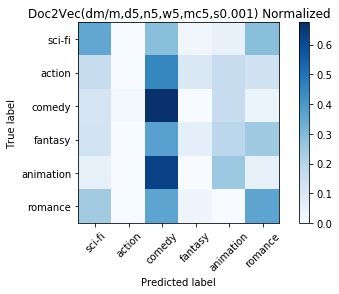

In [88]:
word_embeddings.evaluate_prediction(d2v_model.predict(test_regressors), test_targets, my_tags,title=str(doc2vec_model))

Now let us train KNN model with doc2vec. You will observe how poor the model performs.

2017-06-28 22:13:33,504 : INFO : precomputing L2-norms of doc weight vectors


accuracy 0.201646090535
confusion matrix
 [[ 0 37  1  0  3  1]
 [ 3 26  0  0  2  0]
 [ 2 56 14  1 12  1]
 [ 0 15  0  0  1  0]
 [ 0 24  4  0  6  1]
 [ 1 28  0  0  1  3]]
(row=expected, col=predicted)


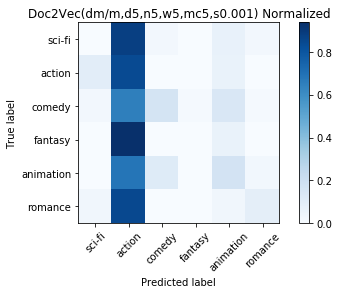

In [89]:
knn_test_predictions = [
    doc2vec_model.docvecs.most_similar([pred_vec], topn=1)[0][0]
    for pred_vec in test_regressors
]
word_embeddings.evaluate_prediction(knn_test_predictions, test_targets,my_tags, str(doc2vec_model))

Since doc2vec also gives us a vector for each genre, we can also observe which genres are similar to each other

In [90]:
doc2vec_model.docvecs.most_similar('action')

[('sci-fi', 0.955485463142395),
 ('animation', 0.9373874068260193),
 ('fantasy', 0.5044772624969482),
 ('comedy', 0.35625192523002625),
 ('romance', 0.09751249849796295)]

In [91]:
doc2vec_model.docvecs.most_similar('fantasy')

[('animation', 0.6903013586997986),
 ('romance', 0.6896251440048218),
 ('action', 0.5044772624969482),
 ('sci-fi', 0.47834616899490356),
 ('comedy', -0.18462462723255157)]

Since words and categories fall in the same vector space, it is possible to also observe which words sorround a tag. Notice how well those words descrive the tag, sci-fi in this case

In [121]:
doc2vec_model.most_similar([doc2vec_model.docvecs['fantasy']])

[('years', 0.9583119750022888),
 ('fell', 0.9185272455215454),
 ('regina', 0.9117251634597778),
 ('marks', 0.9067319631576538),
 ('infected', 0.9006549119949341),
 ('cunning', 0.8974300622940063),
 ('vampires', 0.892426609992981),
 ('skywalker', 0.8912185430526733),
 ('cyborg', 0.8903250098228455),
 ('unfolds', 0.8898645043373108)]

### Visualization

In [93]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


In [94]:
#doc2vec_model.wv.vocab
doc2vec_words = word2vec_helpers.unpack_words_from_doc_vector(doc2vec_model)

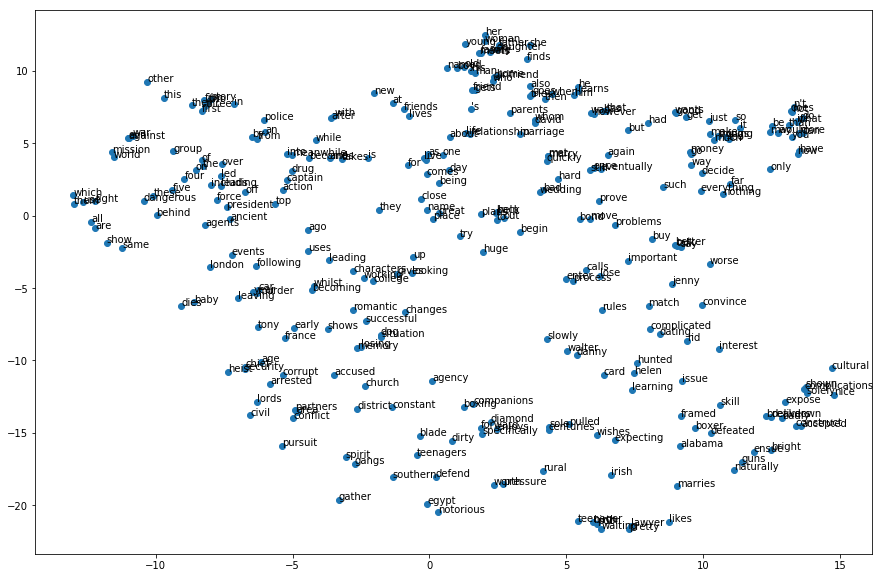

In [95]:
word2vec_helpers.visualize_vectors(doc2vec_model, doc2vec_words)

**Excercise:** Try to visualize words and find interesting clusters. There are so many creative ways to visualize these powerful vector representations

---

## Deep IR

Paper: https://arxiv.org/pdf/1504.07295v3.pdf

This approach is very simple: Train a model for each class or tag and then see which model fits each plot the best using a technique called the [Bayes' Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem). 

Pre-processing: We just clean non-alphanumeric characters and split reviews by sentences.

In [96]:
# The corpus is small so can be read into memory
# here we split plot into sentences
revtrain = list(deepir.plots("training", train_data, test_data))
revtest = list(deepir.plots("test",train_data, test_data))

In [97]:
revtrain[0:1]

[{'x': [['turkish',
    'and',
    'his',
    'close',
    'friend',
    'accomplice',
    'tommy',
    'get',
    'pulled',
    'into',
    'the',
    'world',
    'of',
    'match',
    'fixing',
    'by',
    'the',
    'notorious',
    'brick',
    'top'],
   ['things',
    'get',
    'complicated',
    'when',
    'the',
    'boxer',
    'they',
    'had',
    'lined',
    'up',
    'gets',
    'badly',
    'beaten',
    'by',
    'pitt',
    'pikey',
    'slang',
    'for',
    'an',
    'irish',
    'gypsy',
    'who',
    'comes',
    'into',
    'the',
    'equation',
    'after',
    'turkish',
    'an',
    'unlicensed',
    'boxing',
    'promoter',
    'wants',
    'to',
    'buy',
    'caravan',
    'off',
    'the',
    'irish',
    'gypsies'],
   ['they',
    'then',
    'try',
    'to',
    'convince',
    'pitt',
    'not',
    'only',
    'to',
    'fight',
    'for',
    'them',
    'but',
    'to',
    'lose',
    'for',
    'them',
    'too'],
   ['whilst',
    'a

In [98]:
# shuffle training set for unbiased word2vec training
np.random.shuffle(revtrain)

Let us look at an example from the category sci-fi

In [99]:
next(deepir.tag_sentences(revtrain, ["sci-fi"]))

['in',
 'fascist',
 'future',
 'where',
 'all',
 'forms',
 'of',
 'feeling',
 'are',
 'illegal',
 'man',
 'in',
 'charge',
 'of',
 'enforcing',
 'the',
 'law',
 'rises',
 'to',
 'overthrow',
 'the',
 'system']

In the following steps, we train 6 word2vec models from scratch instead of using the Google pretrained word2vec as in the previous excercises

In [100]:
## training
from gensim.models import Word2Vec
import multiprocessing

In [101]:
## 1. create a w2v learner 
basemodel = Word2Vec(
    workers=multiprocessing.cpu_count(), # use your cores
    iter=100, # iter = sweeps of SGD through the data; more is better
    hs=1, negative=0, # we only have scoring for the hierarchical softmax setup
    )

In [102]:
print(basemodel)

Word2Vec(vocab=0, size=100, alpha=0.025)


In [103]:
basemodel.iter

100

In [104]:
# 2. build a vocabulary
basemodel.build_vocab(deepir.tag_sentences(revtrain, my_tags)) 

2017-06-28 22:13:38,994 : INFO : collecting all words and their counts
2017-06-28 22:13:38,996 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-06-28 22:13:39,056 : INFO : collected 17544 word types from a corpus of 148422 raw words and 7880 sentences
2017-06-28 22:13:39,057 : INFO : Loading a fresh vocabulary
2017-06-28 22:13:39,070 : INFO : min_count=5 retains 3647 unique words (20% of original 17544, drops 13897)
2017-06-28 22:13:39,070 : INFO : min_count=5 leaves 126255 word corpus (85% of original 148422, drops 22167)
2017-06-28 22:13:39,080 : INFO : deleting the raw counts dictionary of 17544 items
2017-06-28 22:13:39,081 : INFO : sample=0.001 downsamples 42 most-common words
2017-06-28 22:13:39,081 : INFO : downsampling leaves estimated 91197 word corpus (72.2% of prior 126255)
2017-06-28 22:13:39,082 : INFO : estimated required memory for 3647 words and 100 dimensions: 5470500 bytes
2017-06-28 22:13:39,085 : INFO : constructing a huffman tree from

In [105]:
from copy import deepcopy
genremodels = [deepcopy(basemodel) for i in range(len(my_tags))]

In [106]:
# 3. training for each model or each tag
for i in range(len(my_tags)):
    slist = list(deepir.tag_sentences(revtrain, my_tags[i]))
    print(my_tags[i], "genre (", len(slist), ")")
    genremodels[i].train(  slist, total_examples=len(slist), epochs=basemodel.iter)

2017-06-28 22:13:39,592 : INFO : training model with 4 workers on 3647 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5


sci-fi genre ( 1157 )


2017-06-28 22:13:40,340 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-06-28 22:13:40,342 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-06-28 22:13:40,345 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-06-28 22:13:40,345 : INFO : worker thread finished; awaiting finish of 0 more threads
2017-06-28 22:13:40,346 : INFO : training on 2163100 raw words (1331086 effective words) took 0.7s, 1780320 effective words/s
2017-06-28 22:13:40,347 : INFO : training model with 4 workers on 3647 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5


action genre ( 1370 )


2017-06-28 22:13:41,269 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-06-28 22:13:41,272 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-06-28 22:13:41,276 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-06-28 22:13:41,278 : INFO : worker thread finished; awaiting finish of 0 more threads
2017-06-28 22:13:41,278 : INFO : training on 2577000 raw words (1598414 effective words) took 0.9s, 1735829 effective words/s
2017-06-28 22:13:41,280 : INFO : training model with 4 workers on 3647 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5


comedy genre ( 2375 )


2017-06-28 22:13:42,287 : INFO : PROGRESS: at 62.38% examples, 1723566 words/s, in_qsize 7, out_qsize 0
2017-06-28 22:13:42,862 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-06-28 22:13:42,863 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-06-28 22:13:42,866 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-06-28 22:13:42,871 : INFO : worker thread finished; awaiting finish of 0 more threads
2017-06-28 22:13:42,872 : INFO : training on 4515700 raw words (2765161 effective words) took 1.6s, 1744093 effective words/s
2017-06-28 22:13:42,873 : INFO : training model with 4 workers on 3647 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5


fantasy genre ( 707 )


2017-06-28 22:13:43,342 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-06-28 22:13:43,345 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-06-28 22:13:43,347 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-06-28 22:13:43,349 : INFO : worker thread finished; awaiting finish of 0 more threads
2017-06-28 22:13:43,349 : INFO : training on 1340700 raw words (822429 effective words) took 0.5s, 1748793 effective words/s
2017-06-28 22:13:43,351 : INFO : training model with 4 workers on 3647 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5


animation genre ( 867 )


2017-06-28 22:13:43,952 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-06-28 22:13:43,958 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-06-28 22:13:43,962 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-06-28 22:13:43,963 : INFO : worker thread finished; awaiting finish of 0 more threads
2017-06-28 22:13:43,963 : INFO : training on 1604300 raw words (972786 effective words) took 0.6s, 1603441 effective words/s
2017-06-28 22:13:43,966 : INFO : training model with 4 workers on 3647 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5


romance genre ( 1404 )


2017-06-28 22:13:44,910 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-06-28 22:13:44,914 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-06-28 22:13:44,915 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-06-28 22:13:44,917 : INFO : worker thread finished; awaiting finish of 0 more threads
2017-06-28 22:13:44,917 : INFO : training on 2641400 raw words (1630692 effective words) took 0.9s, 1725774 effective words/s


Now we will compute the most likely class for each plot using Bayes' Theorem  formula

![alt text](https://docs.google.com/drawings/d/1SRnoMZ6TzZEfswazFhvxcQTrm2EC9lBn3qBVxPpRfXs/pub?w=866&h=424)

In [107]:
probs = deepir.docprob( [r['x'] for r in revtest], genremodels )  

2017-06-28 22:13:44,932 : INFO : scoring sentences with 4 workers on 3647 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2017-06-28 22:13:44,934 : INFO : reached end of input; waiting to finish 9 outstanding jobs
2017-06-28 22:13:44,945 : INFO : scoring 894 sentences took 0.0s, 73422 sentences/s
2017-06-28 22:13:44,946 : INFO : scoring sentences with 4 workers on 3647 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2017-06-28 22:13:44,949 : INFO : reached end of input; waiting to finish 9 outstanding jobs
2017-06-28 22:13:44,960 : INFO : scoring 894 sentences took 0.0s, 66932 sentences/s
2017-06-28 22:13:44,960 : INFO : scoring sentences with 4 workers on 3647 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2017-06-28 22:13:44,961 : INFO : reached end of input; waiting to finish 9 outstanding jobs
2017-06-28 22:13:44,971 : INFO : scoring 894 sentences took 0.0s, 83436 sentences/s
2017-06-28 22:13:44,972 : INFO 

In [108]:
probs[0:2]

,0,1,2,3,4,5
doc,,,,,,
0,0.140609,0.136355,0.314262,0.057756,0.284332,0.066686
1,0.025672,0.333158,0.311374,0.018236,0.000245,0.311316


In [109]:
predictions = probs.idxmax(axis=1).apply(lambda x: my_tags[x])

In [110]:
predictions[0:2]

doc
0    comedy
1    action
dtype: object

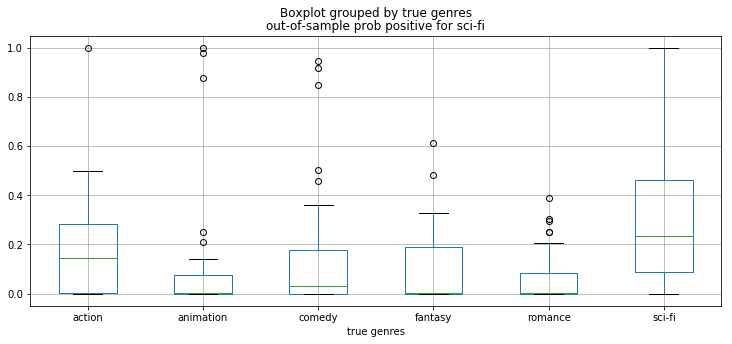

In [111]:
tag_index = 0
col_name = "out-of-sample prob positive for " + my_tags[tag_index]
probpos = pd.DataFrame({col_name:probs[[tag_index]].sum(axis=1), 
                        "true genres": [r['y'] for r in revtest]})
probpos.boxplot(col_name,by="true genres", figsize=(12,5))

The chart above summarizes the probability of each plot being a scifi movie based on the reviews

In [112]:
probpos[0:2]

,out-of-sample prob positive for sci-fi,true genres
doc,,
0,0.140609,comedy
1,0.025672,romance


In [113]:
target = [r['y'] for r in revtest]

accuracy 0.341563786008
confusion matrix
 [[14  2  6  5  7  8]
 [ 4  7  3  7  6  4]
 [11  9 36  7 18  5]
 [ 8  2  1  2  1  2]
 [ 6  4  9  5 10  1]
 [ 6  4  5  1  3 14]]
(row=expected, col=predicted)


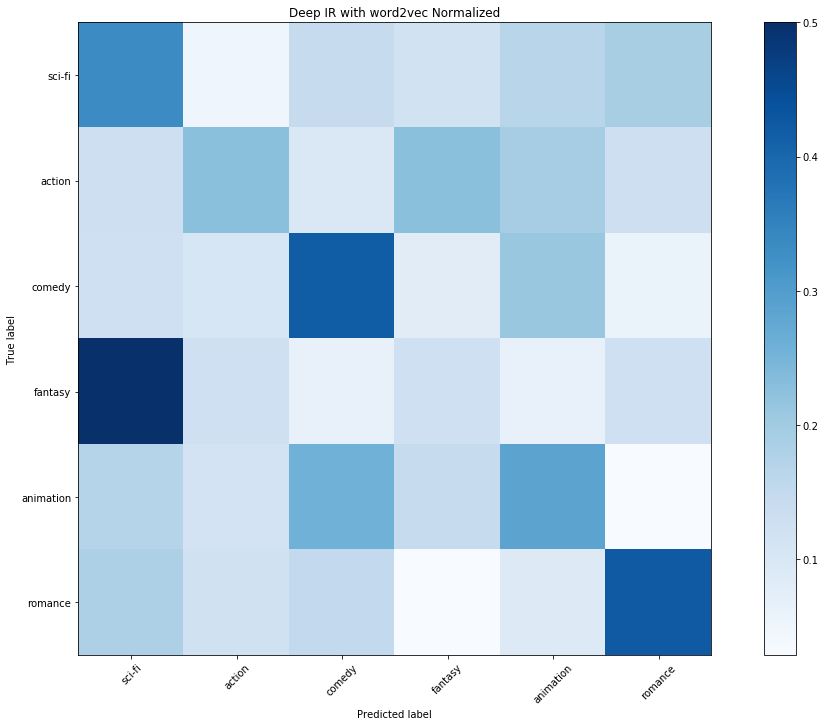

In [114]:
word_embeddings.evaluate_prediction(predictions, target, my_tags, "Deep IR with word2vec")

---

# To Be continued

**Excercise:** Can you explain why we got very bad results for deepir? (Hint: training dataset contains a total of 30K words)

**Excercise:** Feel free to test other approaches proposed by the original authors [here](https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/Document%20classification%20with%20word%20embeddings%20tutorial.ipynb)

 **Excercise:** Experiment with other type of classifiers, like Random Forest Classifiers and Gradient Boost, and if possible, Deep Neural Networks. [More information](http://scikit-learn.org/stable/supervised_learning.html)

**Excercise:** Try to implement different preprocessing methods such as stopwords removal, and those other ones you learned in the Text Mining course

**Excercise:** Create better visualization (always good to know your data)